# Example of application of co-simulation between TVB and Nest

<div class="alert alert-block alert-warning">
    <h1 id="Installation before usage">Installation before usage<a class="anchor-link" href="Installation-before-usage"></a>
        </h1>
    <h3>For running this notebook, there are a lot dependency. For avoid the installation of every tools, you only need to install singularity (https://singularity.lbl.gov/) and donwload the Nest_TVB_full.simg and the notebook.
Once your singularity image and the notebook are in the same folder, you need to lanch the command :</h3>

 <h3>singularity run --app jupyter-notebook ./Nest_TVB_full.simg</h3>

 <h3>The jupyter notebook is launch and you start to run the application</h3>
</div>

In [1]:
%matplotlib notebook
from nest_elephant_tvb.simulation.parameters_manager import save_parameter,create_linked_parameters
from nest_elephant_tvb.analyse.get_data import get_rate,get_data_all
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
param={}

## Define the parameter of the simimulation

In [3]:
param['param_co_simulation']= {"co-simulation": True,
                       "nb_MPI_nest": 8,
                       "record_MPI": False,
                       "id_region_nest": [29,81],
                       "synchronization": 3.5,
                       "level_log": 1,
                       "cluster": False}


## parameter for Nest simulator

In [4]:
param['param_nest'] = {"sim_resolution": 0.1,
                       "master_seed": 46,
                       "total_num_virtual_procs": 14,
                       "overwrite_files": True,
                       "print_time": True,
                       "verbosity": 20}


In [5]:
param['param_nest_topology'] = {"nb_region": 104,
                                "nb_neuron_by_region": 100, 
                                "percentage_inhibitory": 0.2,
                                "neuron_type": "aeif_cond_exp",
                                "param_neuron_excitatory": {"C_m": 200.0, 
                                                            "t_ref": 5.0,
                                                            "V_reset": -64.5, 
                                                            "E_L": -64.5,
                                                            "g_L": 10.0, 
                                                            "I_e": 0.0, 
                                                            "a": 0.0, 
                                                            "b": 1.0,
                                                            "Delta_T": 2.0,
                                                            "tau_w": 500.0, 
                                                            "V_th": -50.0,
                                                            "E_ex": 0.0, 
                                                            "tau_syn_ex": 5.0, 
                                                            "E_in": -80.0, 
                                                            "tau_syn_in": 5.0}, 
                                "param_neuron_inhibitory": {"C_m": 200.0,
                                                            "t_ref": 5.0, 
                                                            "V_reset": -65.0, 
                                                            "E_L": -65.0, 
                                                            "g_L": 10.0, 
                                                            "I_e": 0.0, 
                                                            "a": 0.0, 
                                                            "b": 0.0, 
                                                            "Delta_T": 0.5, 
                                                            "tau_w": 1.0, 
                                                            "V_th": -50.0, 
                                                            "E_ex": 0.0, 
                                                            "tau_syn_ex": 5.0, 
                                                            "E_in": -80.0, 
                                                            "tau_syn_in": 5.0}, 
                                "mean_I_ext": 0.0, 
                                "sigma_I_ext": 0.0, 
                                "sigma_V_0": 0.0, 
                                "mean_w_0": 0.0}


In [6]:
param['param_nest_connection'] = {"path_homogeneous": "/home/nest_elephant_tvb/parameter/data_mouse//connection_homogeneous_", 
                                  "path_heterogeneous": "/home/nest_elephant_tvb/parameter/data_mouse//connection_heterogeneous_", 
                                  "weight_local": 1.0,
                                  "g": 10.0,
                                  "p_connect": 0.05,
                                  "nb_external_synapse": 400,
                                  "path_weight": "/home/nest_elephant_tvb/parameter/data_mouse//weights.npy",
                                  "path_distance": "/home/nest_elephant_tvb/parameter/data_mouse//distance.npy",
                                  "path_centers": "/home/nest_elephant_tvb/parameter/data_mouse//centers.txt", 
                                  "path_region_labels": "/home/nest_elephant_tvb/parameter/data_mouse//region_labels.txt",
                                  "velocity": 3.0,
                                  "weight_global": 1.0}


In [7]:
param['param_nest_background'] = {"poisson": True, 
                                  "rate_ex": 300.4, 
                                  "rate_in": 0.2,
                                  "noise": False,
                                  "mean_noise": 0.0,
                                  "sigma_noise": 400.0, 
                                  "weight_noise": 1.0, 
                                  "stimulus": False,
                                  "stimulus_amplitude": 0.0,
                                  "stimulus_start": 0.0,
                                  "stimulus_duration": 0.0,
                                  "stimulus_target": 0, 
                                  "multimeter": True, 
                                  "multimeter_list": {"pop_1_ex_VM": [["V_m"], 0, 10], 
                                                      "pop_1_ex_W": [["w"], 0, 10], 
                                                      "pop_1_in_VM": [["V_m"], 80, 90],
                                                      "pop_1_in_W": [["w"], 80, 90]}, 
                                  "record_spike": True, 
                                  "record_spike_list": {"pop_1_ex": [0, 79], 
                                                        "pop_2_ex": [100, 179],
                                                        "pop_1_in": [80, 99], 
                                                        "pop_2_in": [180, 199]}, 
                                  "weight_poisson": 1.0}


## parameter for TVB simulator

In [8]:
param['param_tvb_model'] = {"order": 2,
                            "T": 20.0, 
                            "P_e": [-0.05059317, 0.0036078, 0.01794401, 0.00467008, 0.00098553, 0.0082953, -0.00985289, -0.02600252, -0.00274499, -0.01051463], 
                            "P_i": [-0.0596722865, 0.00715675508, 0.00428252163, 0.00925089702, 1.16632197e-06, -0.010065931, 0.00389257235, 0.000445787751, 0.00420050937, 0.00437359879], 
                            "initial_condition": {"E": [0.01, 0.001], 
                                                  "I": [0.0, 0.0], 
                                                  "C_ii": [0.0, 0.0], 
                                                  "W_e": [0.0, 0.0],
                                                  "C_ee": [0.0, 0.0], 
                                                  "C_ei": [0.0, 0.0], 
                                                  "W_i": [0.0, 0.0]}, 
                            "g_L": 10.0,
                            "E_L_e": -64.5, 
                            "E_L_i": -65.0, 
                            "C_m": 200.0,
                            "b_e": 1.0, 
                            "a_e": 0.0, 
                            "b_i": 0.0, 
                            "a_i": 0.0, 
                            "tau_w_e": 500.0, 
                            "tau_w_i": 1.0, 
                            "E_e": 0.0, 
                            "E_i": -80.0, 
                            "Q_e": 1.0, 
                            "Q_i": 10.0, 
                            "tau_e": 5.0, 
                            "tau_i": 5.0, 
                            "N_tot": 1000, 
                            "p_connect": 0.05,
                            "g": 0.2,
                            "K_ext_e": 400}


In [9]:
param['param_tvb_integrator'] = {"tau_OU": 20.0, 
                                 "mu": [0.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                                 "nsig": [0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                                 "weights": [0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                                 "sim_resolution": 0.1, 
                                 "seed": 45, 
                                 "seed_init": 44}


In [10]:
param['param_tvb_coupling'] = {"a": 1.0}


In [11]:
param['param_tvb_connection'] = {"path_distance": "/home/nest_elephant_tvb/parameter/data_mouse//distance.npy",
                                 "path_weight": "/home/nest_elephant_tvb/parameter/data_mouse//weights.npy", 
                                 "nb_region": 104, 
                                 "velocity": 3.0}


In [12]:
param['param_tvb_monitor'] = {"save_time": 20.0,
                              "Raw": False,
                              "TemporalAverage": False,
                              "parameter_TemporalAverage": {"variables_of_interest": [0, 1, 2, 3],
                                                            "period": 1.0}, 
                              "Bold": False, 
                              "parameter_Bold": {"variables_of_interest": [0], 
                                                 "period": 2000.0}
                             }


## parameter for translator nest to TVB

In [13]:
param['param_TR_nest_to_tvb'] = {
                                 "resolution": 0.1,
                                 "nb_neurons": 800.0,
                                 "synch": 6.0,
                                 "width": 20.0,
                                 "level_log": 1}


## parameter for translator TVB to Nest

In [14]:
param['param_TR_tvb_to_nest'] = {"percentage_shared": 0.01,
                                 "level_log": 1, 
                                 "seed": 43,
                                 "nb_synapses": 400}



## parameter for the simulation

In [15]:
begin=0.0
end=100.0
folder_simulation = './test_sim/'

## save parameters

In [16]:
if not os.path.exists(folder_simulation):
    os.mkdir(folder_simulation)
parameters = create_linked_parameters(folder_simulation,param)
save_parameter(parameters,folder_simulation,begin,end)

## run the simulation

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=10;


In [17]:
!mpirun -n 1 /usr/bin/python3.7 /home/nest_elephant_tvb/simulation/run_exploration.py {folder_simulation}/parameter.py

<IPython.core.display.Javascript object>

In [18]:
!mpirun -n 1 /usr/bin/python3.7 /home/nest_elephant_tvb/simulation/run_exploration.py {folder_simulation}/parameter.py

[INFO] [2020.6.25 16:2:43 /home/nest-io-dev/nestkernel/rng_manager.cpp:208 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2020.6.25 16:2:43 /home/nest-io-dev/nestkernel/rng_manager.cpp:251 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: UNKNOWN
 Built: Jun 25 2020 09:55:02

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

2020-06-25 16:02:44,005 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO
time: 2020-06-25 16:02:44.376045 BEGIN SIMULATION 

Time to initialize the network: 0.02 s
[0, 80]
[80, 100]
[0, 80]
[80, 100]
2020-06-25 16:02:45,162 - WARNING - tvb.simulator.common - psutil module not

In [19]:
%%javascript
IPython.OutputArea.auto_scroll_threshold=100;

<IPython.core.display.Javascript object>

## plot firing rate

In [20]:
rate = get_rate(folder_simulation+'/tvb/')

<IPython.core.display.Javascript object>


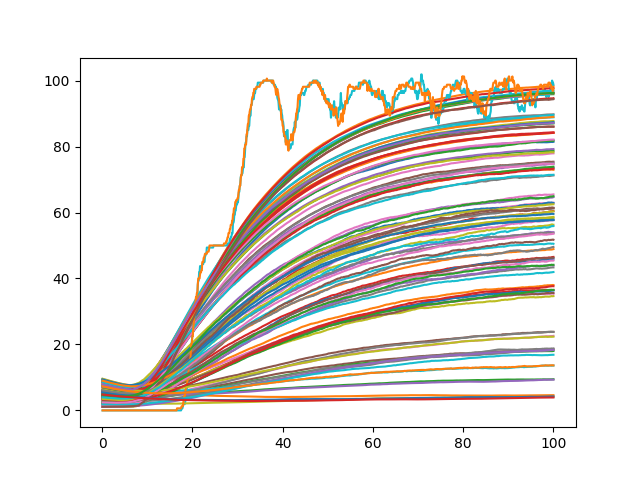

<IPython.core.display.Javascript object>


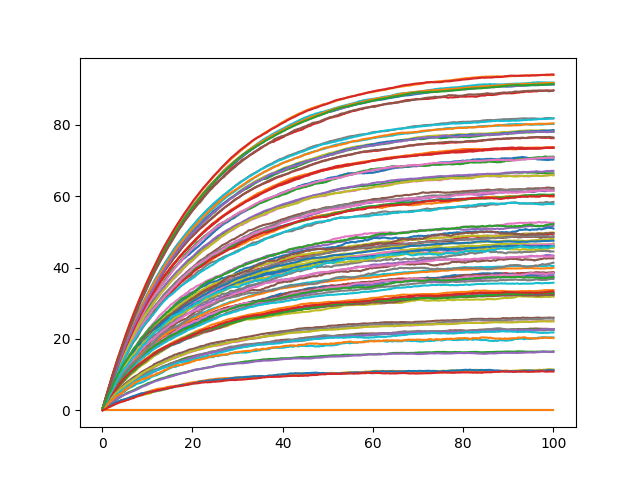

<IPython.core.display.Javascript object>


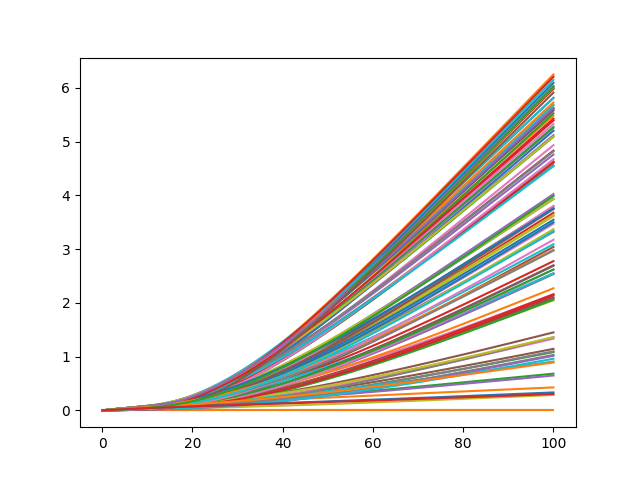

In [21]:
plt.subplot()
plt.plot(rate[0][0],np.concatenate(rate[0][1]).reshape(rate[0][1].shape[0],7,104,1)[:,0,:,0]*1e3)
plt.figure()
plt.plot(rate[0][0],np.concatenate(rate[0][1]).reshape(rate[0][1].shape[0],7,104,1)[:,1,:,0]*1e3)
plt.figure()
plt.plot(rate[0][0],np.concatenate(rate[0][1]).reshape(rate[0][1].shape[0],7,104,1)[:,5,:,0])
plt.show()

In [22]:
data = get_data_all(folder_simulation+'/nest/')

/home/nest_elephant_tvb/analyse/get_data.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return [ids,np.array(spikes)]


<IPython.core.display.Javascript object>


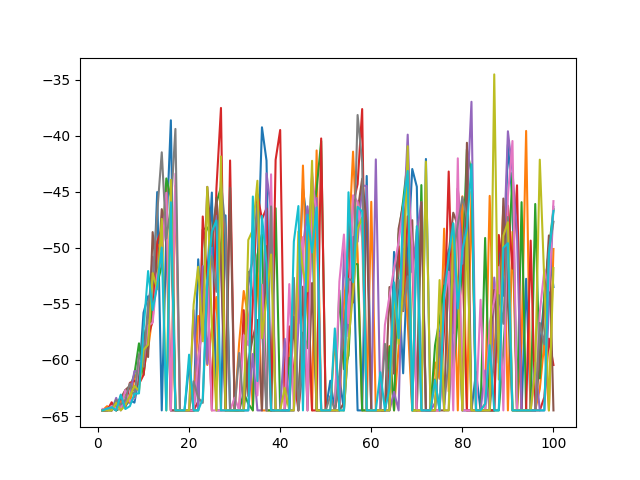

In [23]:
plt.figure()
plt.plot(data[0][1],np.swapaxes(data[0][2],0,1))
plt.show()

<IPython.core.display.Javascript object>


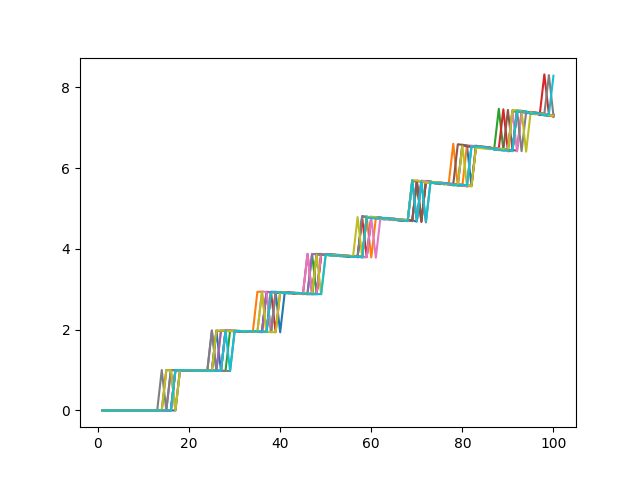

In [24]:
plt.figure()
plt.plot(data[1][1],np.swapaxes(data[1][2],0,1))
plt.show()

<IPython.core.display.Javascript object>


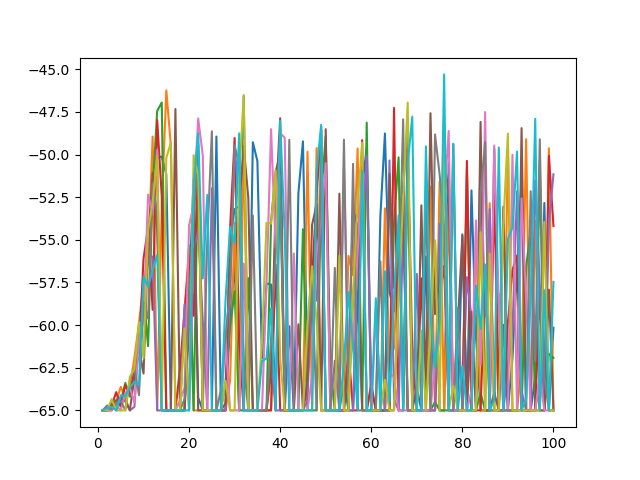

In [25]:
plt.figure()
plt.plot(data[2][1],np.swapaxes(data[2][2],0,1))
plt.show()

<IPython.core.display.Javascript object>


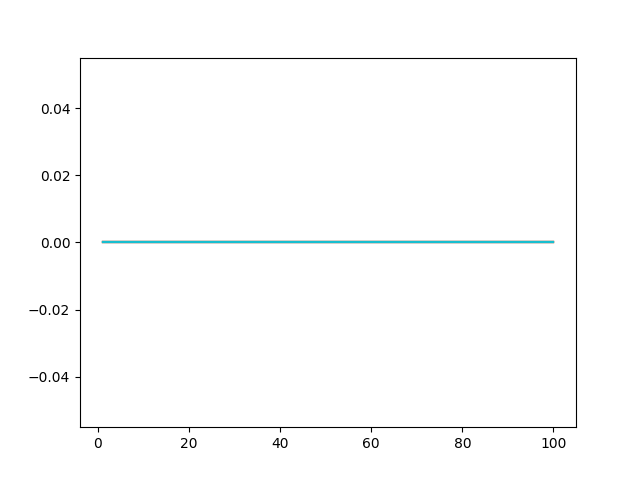

In [26]:
plt.figure()
plt.plot(data[3][1],np.swapaxes(data[3][2],0,1))
plt.show()

<IPython.core.display.Javascript object>


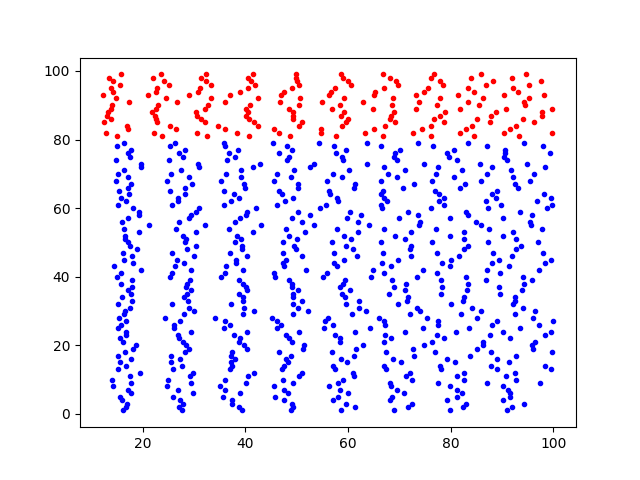

In [27]:
plt.figure()
for i in range(data[4][0].shape[0]):
    plt.plot(data[4][1][i],np.repeat(data[4][0][i],data[4][1][i].shape[0]),'b.')
for i in range(data[6][0].shape[0]):
    plt.plot(data[6][1][i],np.repeat(data[6][0][i],data[6][1][i].shape[0]),'r.')
plt.show()

<IPython.core.display.Javascript object>


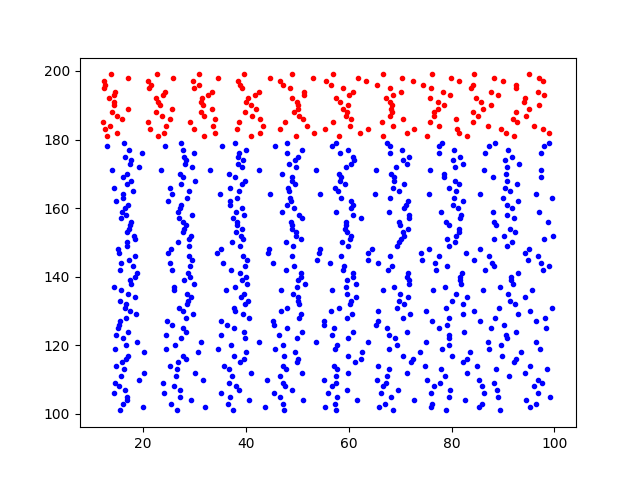

In [28]:
plt.figure()
for i in range(data[5][0].shape[0]):
    plt.plot(data[5][1][i],np.repeat(data[5][0][i],data[5][1][i].shape[0]),'b.')
for i in range(data[7][0].shape[0]):
    plt.plot(data[7][1][i],np.repeat(data[7][0][i],data[7][1][i].shape[0]),'r.')
plt.show()